# Showcases of `tfplot`

This guide shows a quick tour of the `tfplot` library. Please skip the setup section of this document.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# override ipython style
from IPython.display import display_html, HTML, display
HTML("""<style>
.text_cell_render h1 { background: #b2f2bb; padding: 10px; }
.text_cell_render h2 { background: #ffec99; padding: 10px; }
</style>""")

In [3]:
# additional requirements:
#   scipy scikit-image Pillow seaborn

import numpy as np
from PIL import Image
import scipy.misc

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams, rc
from IPython.core.pylabtools import figsize

%config InlineBackend.figure_format = 'retina'

In [5]:
import tfplot
tfplot.__version__

'0.3.0.dev0'

## Setup: Utilities and Data

In order to see the images generated from the plot ops, we introduce a simple utility function which takes a `Tensor` as an input and displays the resulting image after executing it in a TensorFlow session.

You may want to skip this section to have the showcase started.

In [6]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [7]:
def execute_op_as_image(op):
    """
    Evaluate the given `op` and return the content PNG image as `PIL.Image`.
    
    - If op is a plot op (e.g. RGBA Tensor) the image or
      a list of images will be returned
    - If op is summary proto (i.e. `op` was a summary op),
      the image content will be extracted from the proto object.
    """
    print ("Executing: " + str(op))
    ret = sess.run(op)
    plt.close()

    if isinstance(ret, np.ndarray):
        if len(ret.shape) == 3:
            # single image
            return Image.fromarray(ret)
        elif len(ret.shape) == 4:
            return [Image.fromarray(r) for r in ret]
        else:
            raise ValueError("Invalid rank : %d" % len(ret.shape))            
            
    elif isinstance(ret, (str, bytes)):
        from io import BytesIO
        s = tf.Summary()
        s.ParseFromString(ret)
        ims = []
        for i in range(len(s.value)):
            png_string = s.value[i].image.encoded_image_string
            im = Image.open(BytesIO(png_string))
            ims.append(im)
        plt.close()
        if len(ims) == 1: return ims[0]
        else: return ims
        
    else:
        raise TypeError("Unknown type: " + str(ret))

and some data:

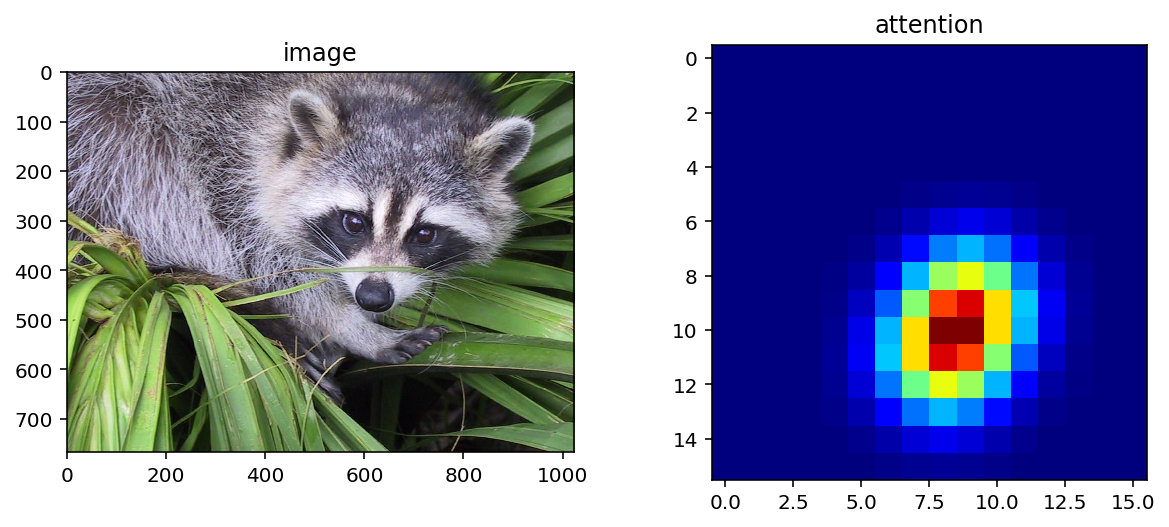

In [8]:
def fake_attention():
    import scipy.ndimage
    attention = np.zeros([16, 16], dtype=np.float32)
    attention[(11, 8)] = 1.0
    attention[(9, 9)] = 1.0
    attention = scipy.ndimage.filters.gaussian_filter(attention, sigma=1.5)
    return attention

sample_image = scipy.misc.face()
attention_map = fake_attention()

# display the data
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(sample_image); axs[0].set_title('image')
axs[1].imshow(attention_map, cmap='jet'); axs[1].set_title('attention')
plt.show()

And we finally wrap these numpy values into TensorFlow ops:

In [9]:
# the input to plot_op
image_tensor = tf.constant(sample_image, name='image')
attention_tensor = tf.constant(attention_map, name='attention')
print(image_tensor)
print(attention_tensor)

Tensor("image:0", shape=(768, 1024, 3), dtype=uint8)
Tensor("attention:0", shape=(16, 16), dtype=float32)


## 1. `tfplot.autowrap`: The Main End-User API

Use [tfplot.autowrap](https://tensorflow-plot.readthedocs.io/en/latest/api/tfplot.html#tfplot.autowrap) to design a custom plot function of your own.

### Decorator to define a TF op that draws plot

With `tfplot.autowrap`, you can wrap a python function that returns `matplotlib.Figure` (or `AxesSubPlot`) into TensorFlow ops, similar as in `tf.py_func`.

Executing: Tensor("plot_scatter:0", shape=(?, ?, 4), dtype=uint8)


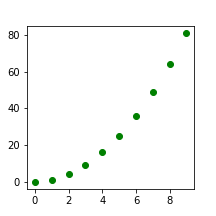

In [10]:
@tfplot.autowrap
def plot_scatter(x, y):
    # NEVER use plt.XXX, or matplotlib.pyplot.
    # Use tfplot.subplots() instead of plt.subplots() to avoid thread-safety issues.
    fig, ax = tfplot.subplots(figsize=(3, 3))
    ax.scatter(x, y, color='green')
    return fig

x = tf.constant(np.arange(10), dtype=tf.float32)
y = tf.constant(np.arange(10) ** 2, dtype=tf.float32)
execute_op_as_image(plot_scatter(x, y))

We can create subplots as well. Also, note that additional arguments (i.e. kwargs) other than Tensor arguments (i.e. positional arguments) can be passed.

Executing: Tensor("plot_image_and_attention:0", shape=(?, ?, 4), dtype=uint8)


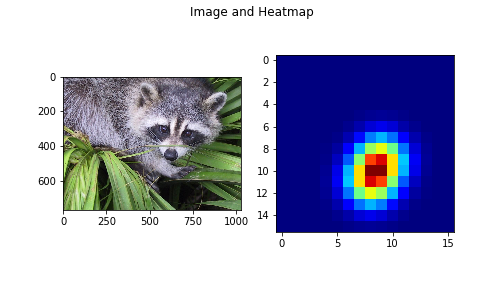

In [11]:
@tfplot.autowrap
def plot_image_and_attention(im, att, cmap=None):
    fig, axes = tfplot.subplots(1, 2, figsize=(7, 4))
    fig.suptitle('Image and Heatmap')
    axes[0].imshow(im)
    axes[1].imshow(att, cmap=cmap)
    return fig

op = plot_image_and_attention(sample_image, attention_map, cmap='jet')
execute_op_as_image(op)

Sometimes, it can be cumbersome to create instances of `fig` and `ax`. If you want to have them **automatically** created and injected, use a keyword argument named `fig` and/or `ax`:

Executing: Tensor("plot_scatter_1:0", shape=(?, ?, 4), dtype=uint8)


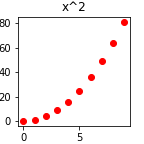

In [12]:
@tfplot.autowrap(figsize=(2, 2))
def plot_scatter(x, y, *, ax, color='red'):
    ax.set_title('x^2')
    ax.scatter(x, y, color=color)

x = tf.constant(np.arange(10), dtype=tf.float32)
y = tf.constant(np.arange(10) ** 2, dtype=tf.float32)
execute_op_as_image(plot_scatter(x, y))

## 2. Wrapping Matplotlib's AxesPlot or Seaborn Plot

You can use `tfplot.autowrap` (or raw APIs such as `tfplot.plot`, etc.) to plot *anything* by writing a customized plotting function on your own, but sometimes we may want to convert already existing plot functions from common libraries such as `matplotlib` and `seaborn`.

To do this, you can still use `tfplot.autowrap`.

### Matplotlib

Matplotlib provides a variety of plot methods defined in the class `AxesPlot` (usually, `ax`).

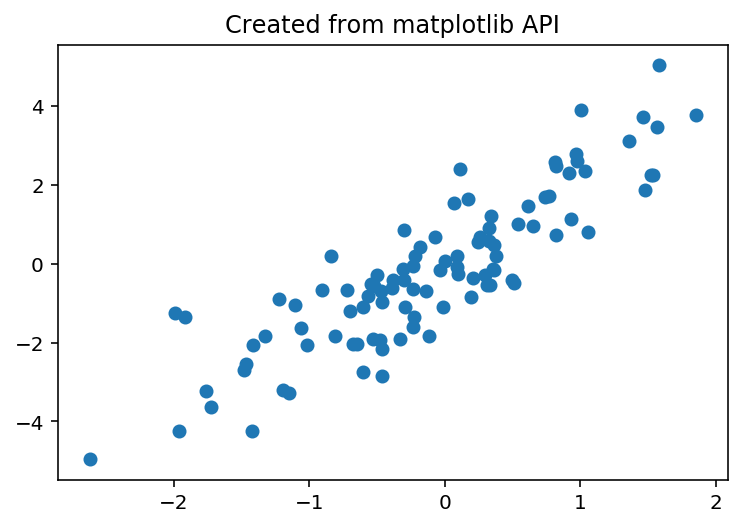

In [13]:
rs = np.random.RandomState(42)
x = rs.randn(100)
y = 2 * x + rs.randn(100)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("Created from matplotlib API")
plt.show()

We can wrap the `Axes.scatter()` method as TensorFlow op as follows:

Executing: Tensor("scatter:0", shape=(?, ?, 4), dtype=uint8)


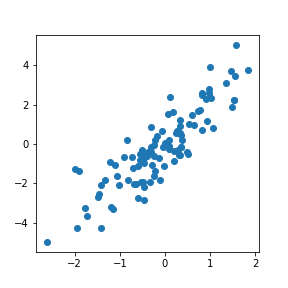

In [14]:
from matplotlib.axes import Axes
tf_scatter = tfplot.autowrap(Axes.scatter, figsize=(4, 4))

plot_op = tf_scatter(x, y)
execute_op_as_image(plot_op)

### Seaborn

Seaborn provides many useful axis plot functions that can be used out-of-box. Most of functions for drawing an `AxesPlot` will have the `ax=...` parameter.

See [seaborn's example gallery](https://seaborn.pydata.org/examples/index.html) for interesting features `seaborn` provides.

In [15]:
import seaborn as sns

assert sns.__version__ >= '0.8', \
    'Use seaborn >= v0.8.0, otherwise `import seaborn as sns` will affect the default matplotlib style.'

#### barplot: (Discrete) Probability Distribution

Executing: Tensor("barplot:0", shape=(?, ?, 4), dtype=uint8)


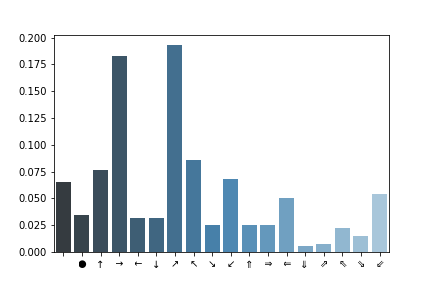

In [16]:
# https://seaborn.pydata.org/generated/seaborn.barplot.html
    
y = np.random.RandomState(42).normal(size=[18])
y = np.exp(y) / np.exp(y).sum() # softmax
y = tf.constant(y, dtype=tf.float32)

ATARI_ACTIONS = [
    '⠀', '●', '↑', '→', '←', '↓', '↗', '↖', '↘', '↙',
    '⇑', '⇒', '⇐', '⇓', '⇗', '⇖', '⇘', '⇙' ]
x = tf.constant(ATARI_ACTIONS)

op = tfplot.autowrap(sns.barplot, palette='Blues_d')(x, y)
execute_op_as_image(op)

Executing: Tensor("barplot_1/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


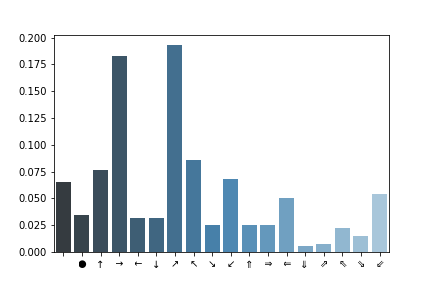

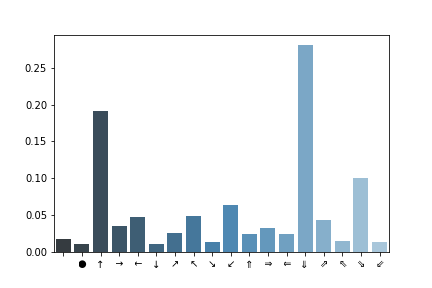

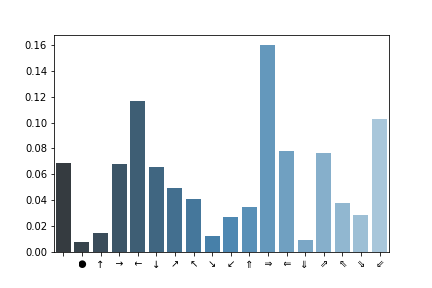

In [17]:
y = np.random.RandomState(42).normal(size=[3, 18])
y = np.exp(y) / np.exp(y).sum(axis=1).reshape([-1, 1]) # softmax example-wise
y = tf.constant(y, dtype=tf.float32)

ATARI_ACTIONS = [
    '⠀', '●', '↑', '→', '←', '↓', '↗', '↖', '↘', '↙',
    '⇑', '⇒', '⇐', '⇓', '⇗', '⇖', '⇘', '⇙' ]
x = tf.broadcast_to(tf.constant(ATARI_ACTIONS), y.shape)

op = tfplot.autowrap(sns.barplot, palette='Blues_d', batch=True)(x, y)
for im in execute_op_as_image(op):
    display(im)

#### Heatmap

Let's wrap seaborn's `heatmap` function, as TensorFlow operation, with some additional default kwargs. This is very useful for visualization.

Executing: Tensor("heatmap:0", shape=(?, ?, 4), dtype=uint8)


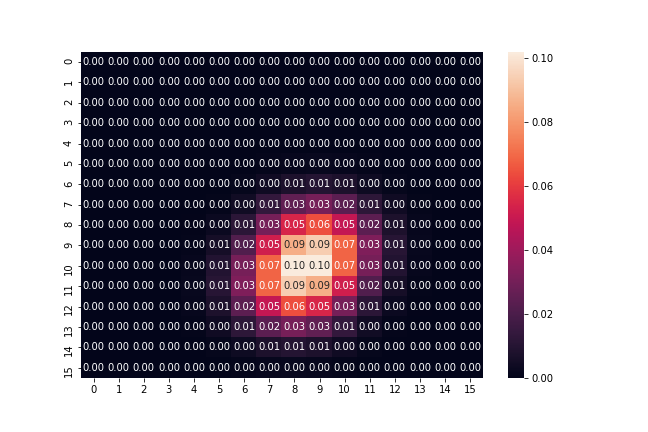

In [18]:
# @seealso https://seaborn.pydata.org/examples/heatmap_annotation.html
tf_heatmap = tfplot.autowrap(sns.heatmap, figsize=(9, 6))

op = tf_heatmap(attention_map, cbar=True, annot=True, fmt=".2f")
execute_op_as_image(op)

What if we don't want axes and colorbars, but only the map itself? Compare to plain `tf.summary.image`, which just gives a grayscale image.

Executing: Tensor("HeatmapImage:0", shape=(?, ?, 4), dtype=uint8)


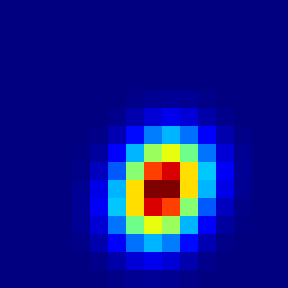

In [19]:
# print only heatmap figures other than axis, colorbar, etc.
tf_heatmap = tfplot.autowrap(sns.heatmap, figsize=(4, 4), tight_layout=True,
                             cmap='jet', cbar=False, xticklabels=False, yticklabels=False)

op = tf_heatmap(attention_map, name='HeatmapImage')
execute_op_as_image(op)

<br><br><br>

## And Many More!

This document has covered a basic usage of `tfplot`, but there are a few more:

* `tfplot.contrib`: contains some off-the-shelf functions for creating plot operations that can be useful in practice, in few lines (without a hassle of writing function body). See [contrib.ipynb] for more tour of available APIs.

* `tfplot.plot()`, `tfplot.plot_many()`, etc.: Low-level APIs.

* `tfplot.summary`: One-liner APIs for creating TF summary operations.

In [21]:
import tfplot.contrib

For example, `probmap` and `probmap_simple` create an image Tensor that visualizes a probability map:

Executing: Tensor("probmap:0", shape=(?, ?, 4), dtype=uint8)


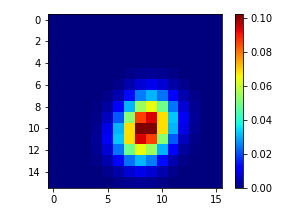

In [22]:
op = tfplot.contrib.probmap(attention_map, figsize=(4, 3))
execute_op_as_image(op)

Executing: Tensor("probmap_1:0", shape=(?, ?, 4), dtype=uint8)


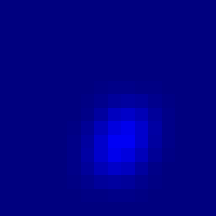

In [23]:
op = tfplot.contrib.probmap_simple(attention_map, figsize=(3, 3), vmin=0, vmax=1)
execute_op_as_image(op)

<br><br><br>

That's all! Please take a look at API documentations and more examples if you are interested.